# Step 1: create_model.ipynb
* Made by Vivian Tao
* Last update by Vivian Tao (June 16, 2025)

This file creates and trains a classifier model using trackpy analysis and corresponding labeled data.

Please create the labeled data sheet as an excel file with columns 'particle' and 'dead/alive (0/1)'.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pims
import trackpy as tp
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import joblib

## Upload Image Sequence Folders

IMPORTANT NOTES: Please upload as many image sequence folders as you like, depending 
on what data you have labeled. Please make a separate label file for each image sequence folder, repeating the next 3 lines for each folder.

In [ ]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]

# for files with RGB
# frames = gray(pims.open("data2/day4_background/*.tif*"))

# for other files
frames = pims.open("../../../ambdata/day1_background/*.tif*")

# load in labeled data with particle numbers
label = pd.read_excel("../../../amb_trainingdata/day1_select.xlsx")
# sets the particle number as the index - useful for combining with tracking data
label.set_index('particle', inplace=True)

### MICRONS PER PIXEL (upp) REFERENCE:
** for 1024x768 pixels **

In [ ]:
UPP_4X = 10/5.567
UPP_10X = 10/13.9735
UPP_20X = 10/28.068
UPP_40X = 10/54.504

## Functions

In [ ]:
# returns a numpy array of the diagonal size of each particle trajectory corresponding to the particle number in array parameter (in microns)
def get_diagonal_size(array, df, upp):
    lengths = []

    for particle in array:
        lengths.append(tp.diagonal_size(df[df["particle"] == particle], pos_columns=None, t_column='frame'))

    lengths = np.array(lengths)
    return lengths * upp

# returns a linear model for curve fitting - used with power law fitting
def linear_model(x, A, B):
	y = A + B * x
	return y

# returns best fit power law exponents (1 is linear = brownian motion, >1 is superdiffusive, <1 is subdiffusive) and the error of the fit
def fit_powerlaw(x, y):
	x = np.log(x)
	y = np.log(y)
	fit, dfit = curve_fit(linear_model, x, y, absolute_sigma = True)
	return fit[1], np.sqrt(dfit[1,1])


# returns numpy array of powers for each particle, with 0 if the power cannot be calculated (not enough frames) and 
# a numpy array of the maximum msd for each particle
def calc_msd(array, df, fps, upp):
	power = []
	lengths = []
	max_msd = []
	for particle in array:
		a = tp.msd(df[df['particle']==particle], upp, fps)
		a = a[a['msd'] != 0] # removes rows of a specific lagtime where parts of calculation includes NaN's or inf's.
		x = a['lagt']
		y = a['msd']
		lengths.append(len(x))
		if len(x) > 10: #and not np.any(y==0):
			c, a = fit_powerlaw(x, y)
			power.append(c)
			max_msd.append(np.max(y))
		else:
			power.append(0)
	power = np.array(power)
	max_msd = np.array(max_msd)
	return power, max_msd

# returns a numpy array of the number of frames for each particle, which is used as the path length
def calc_traj_length(array, df, upp):
    length = []
    df = df.loc[df['particle'].isin(array)]
    window = 10
    for id, group in df.groupby('particle'):
        dx = group['x'].diff(periods=window)
        dy = group['y'].diff(periods=window)
        ds = np.sqrt(dx**2 + dy**2)
        ds.dropna(inplace=True)
        if (ds.empty):
            length.append(-1)
        else:
            length.append(np.sum(ds))
    length = np.array(length)

    return length * upp


In [ ]:
# returns a dataframe with the diagonal size, msd power, and straightness for each particle
def create_df(bact_size, min_mass, frames, labeled_df, fps, upp):
    # detect particles
    for i in [0]: # or use [::50] for every 50th frame
        df = tp.locate(frames[i], bact_size, invert=True, minmass=min_mass)
    
    # link to form trajectories
    df = tp.batch(frames[:], bact_size, invert=True, minmass=min_mass)
    tp.quiet(suppress=True)
    df = tp.link_df(df, 20, memory=10)
    df = tp.filter_stubs(df, 5)
    df = tp.subtract_drift(df)
    df.index.names = ["frame", "index"]

    # create list of particles (arr)
    num_trajectories = df["particle"].max()
    traj_range = np.linspace(0, num_trajectories, num=num_trajectories+1)
    arr = []
    for i in traj_range:
        if not df[df['particle']==i].empty:
            arr.append(i)
    arr = np.array(arr)

    # combine into one dataframe
    total_diagonal_lengths = get_diagonal_size(arr, df, upp)
    total_msd_powers, total_max_msd = calc_msd(arr, df, fps, upp)
    total_straightness = total_diagonal_lengths / calc_traj_length(arr, df, upp)
    total = pd.DataFrame({'particle': arr, 'diagonal size': total_diagonal_lengths, 'msd power': total_msd_powers, 'straightness': total_straightness})

    # convert particle numbers to integers and set as index
    total['particle'] = total['particle'].astype(int)
    total.set_index('particle', inplace=True)
    # add labels to the dataframe
    total = total.join(labeled_df, lsuffix='_left', rsuffix='_right', how='left').dropna()

    return total


## Create, Train, and Test Model

In [ ]:
df = create_df(15, 100000, frames, label, 10, UPP_40X)

In [ ]:
# if you used multiple image sequences, combine the dataframes here into one large dataframe
# total = pd.concat([df1, df2, df3, df4, df5])

# otherwise, rename as total for consistency
total = df

# if you want to combine current dataframes with a saved csv dataframe:
other_data = pd.read_csv("formatted_data.csv", index_col='particle')
total = pd.concat([total, other_data])

# optionally, save the dataframe to a CSV file to make it easier to create a model later
total.to_csv("formatted_data_2.csv")
print(total.to_string())

          diagonal size  msd power  straightness  dead/alive (0/1)
particle                                                          
0             12.304715  -0.038610      0.188263               0.0
1             26.822820   1.061392      0.171148               0.0
3             30.318324   1.104505      0.163735               0.0
4             28.201087   0.863520      0.154725               0.0
5             23.957100   0.677046      0.262674               0.0
6             30.662369   0.760352      0.081314               0.0
7             25.941299   0.471648      0.191842               0.0
9             25.449111   0.836990      0.130157               0.0
10            23.701126   0.296141      0.058012               0.0
11            23.527497   0.629671      0.098545               0.0
12            26.125621   0.773958      0.128933               0.0
13            16.657989   0.234252      0.384721               0.0
14            26.641691   0.470430      0.213251              

In [16]:
features = total[['diagonal size', 'msd power', 'straightness']]
target = total["dead/alive (0/1)"]

# splits the dataframe into training and testing
# random_state = 42 ensures pseudo-random results that will result in the same thing every time this is run
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

# optionally, scale the features. This is useful for some classifiers, but actually might be detrimental for this one (because
# living bacteria might be viewed as outliers)
'''
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)
'''

# creates classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42) # creates 100 trees
# trains classifier
classifier.fit(features_train, target_train)
# tests classifier
target_pred = classifier.predict(features_test)

## Check Accuracy

Accuracy: 100.00%


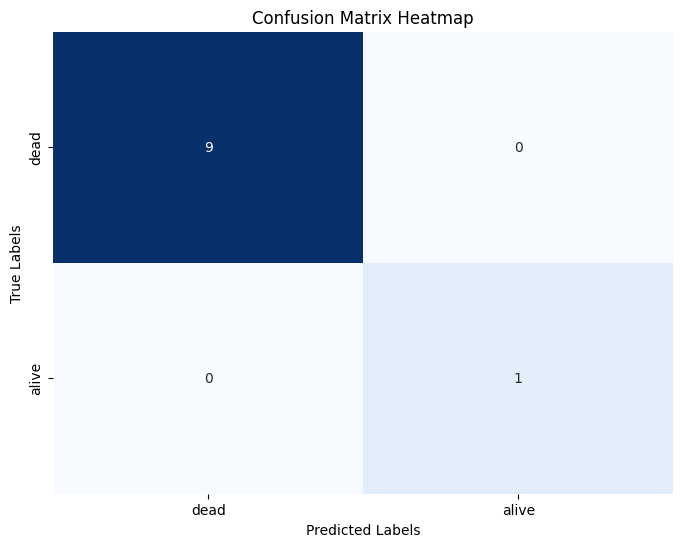

In [17]:
# computes accuracy and confusion matrix
accuracy = accuracy_score(target_test, target_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(target_test, target_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=['dead', 'alive'], yticklabels=['dead', 'alive'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

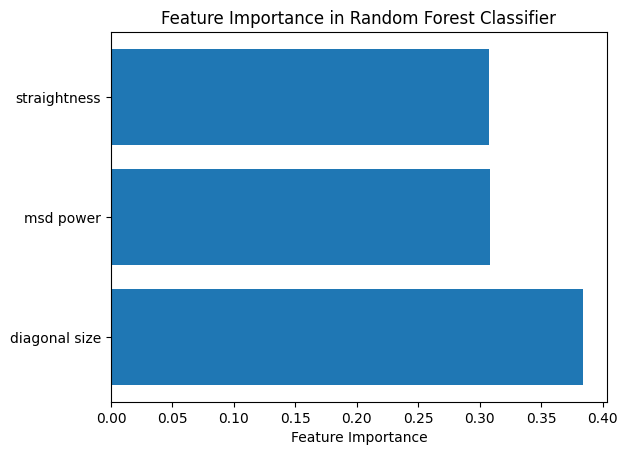

In [18]:
# plots feature importances
feature_importances = classifier.feature_importances_

plt.barh(['diagonal size', 'msd power', 'straightness'], feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [19]:
# saves the classifier to a file for later use in classify.ipynb
joblib.dump(classifier, 'test1_classifier.joblib')

['test1_classifier.joblib']

# ~ END OF MAIN FILE CONTENT ~

## Other helpful operations

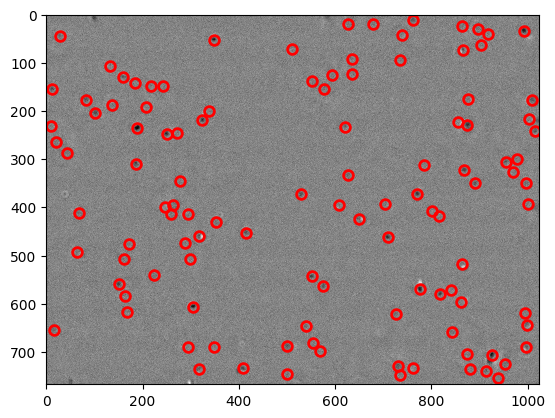

112


<Figure size 640x480 with 0 Axes>

In [20]:
BACT_SIZE = 17 # must be an odd integer, better to be on the larger end
MIN_MASS = 100000
sub_drift = True



for i in [0]: # or use [::50] for every 50th frame
    f = tp.locate(frames[i], BACT_SIZE, invert=True, minmass=MIN_MASS)
    plt.imshow(frames[i])
    tp.annotate(f, frames[i], plot_style={'markersize': 7})
    plt.clf()

print(len(f))


In [21]:
f = tp.batch(frames[:], BACT_SIZE, invert=True, minmass=MIN_MASS)
tp.quiet(suppress=True)

In [22]:
t = tp.link_df(f, 20, memory=10)
t1 = tp.filter_stubs(t, 5)
t1 = tp.subtract_drift(t1)

if sub_drift == True:
	t1.index.names = ["frame", "index"] # the data structure changes when you subtract drift, we're switching it back

In [23]:
num_trajectories = t1["particle"].max()

traj_range = np.linspace(0, num_trajectories, num=num_trajectories+1)
arr = []
for i in traj_range:
    if not t1[t1['particle']==i].empty:
        arr.append(i)
arr = np.array(arr)
# arr stores numbers of all particles with non-empty trajectories

#arr = np.linspace(0, 4225, num=846)
print("number of ALL trajectories: %d" % (num_trajectories))
print("number of non-empty trajectories: %d" % (len(arr)))

number of ALL trajectories: 753
number of non-empty trajectories: 319


/Users/viviantao/Documents/Johns Hopkins/research/MTB/count/.venv/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]
/Users/viviantao/Documents/Johns Hopkins/research/MTB/count/.venv/lib/python3.13/site-packages/trackpy/plots.py:356: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


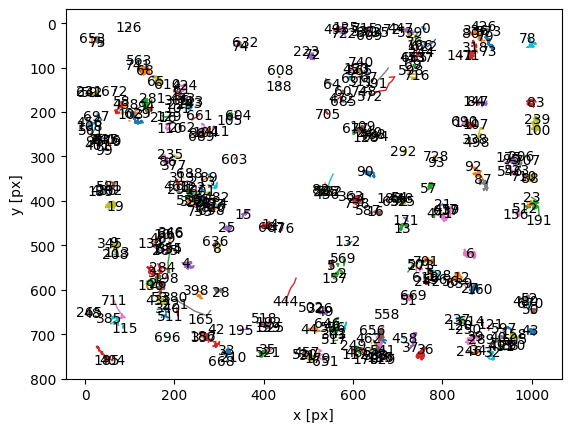

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [24]:
# plot trajectories with labels in original orientation
tp.plot_traj(t1, label=True)

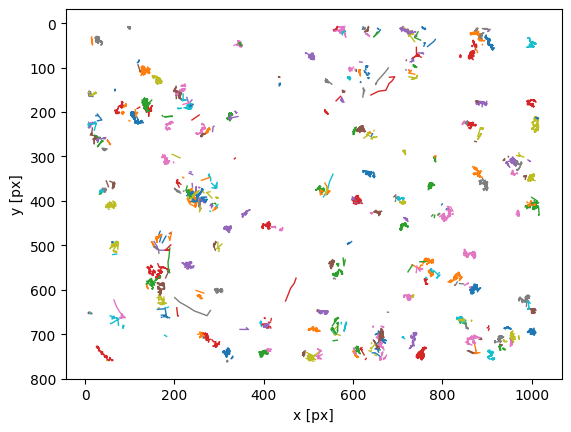

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [25]:
# plot trajectories in original orientation
tp.plot_traj(t1, label=False)

(0.0, 800.0)

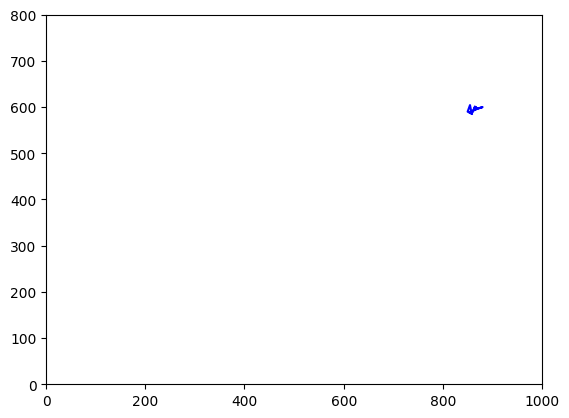

In [26]:
# plot a single trajectory of a living particle in original orientation with a specific particle number NUM
NUM = 27
plt.plot(t1[t1['particle']==NUM]['x'], t1[t1['particle']==NUM]['y'], '-b', label="living")
plt.xlim(0,1000)
plt.ylim(0,800)